## Análisis Directividad

In [1]:
import os
import sounddevice as sd
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import librosa as li
from scipy import signal
from scipy import fft
import pandas as pd

In [2]:
sd.query_devices()

  0 Asignador de sonido Microsoft - Input, MME (2 in, 0 out)
> 1 Microphone (DroidCam Virtual Au, MME (1 in, 0 out)
  2 Asignador de sonido Microsoft - Output, MME (0 in, 2 out)
< 3 Speakers (High Definition Audio, MME (0 in, 2 out)
  4 1 - HDMI    (AMD High Definitio, MME (0 in, 2 out)
  5 Output (AMD HD Audio HDMI out #0), Windows WDM-KS (0 in, 2 out)
  6 MIDI (DroidCam Audio), Windows WDM-KS (1 in, 0 out)
  7 Output (DroidCam Audio), Windows WDM-KS (0 in, 1 out)
  8 Speakers (HD Audio Speaker), Windows WDM-KS (0 in, 2 out)

In [2]:
sd.default.device = 1
fs = 48000

### Importación de Archivos, Segmentación y Guardado de Muestras

Leemos todos los archivos de audio, detectamos las secciones donde no hay silencio y guardamos cada muestra en un dataframe, con metadatos extraidos del nombre de archivo de su correspondiente wav.

A4_69_4hPa_Tapa Izquierda_Abriendo_Uhlig_Apuntado mic 1_Laboratorio LAPSo_2023-10-12_16-40.wav


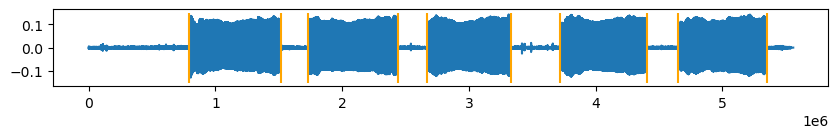

5 muestras extraídas.


B2_47_4hPa_Tapa Izquierda_Abriendo_Uhlig_Apuntado mic 1_Laboratorio LAPSo_2023-10-12_16-32.wav


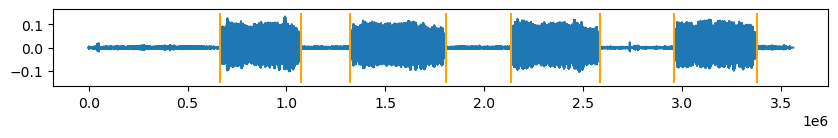

4 muestras extraídas.




KeyboardInterrupt: 

In [137]:
path = "Grabaciones Bandoneon/"
# Guardamos todos los nombres de archivo en una lista
files_list = os.listdir(path)

# Variables para los cortes
topdb = 16
framelength = 10
margen = 3000  # Margen para recortar los samples (en muestras)

# Dataframe para guardar los datos
df = pd.DataFrame(
    columns=[
        "Nota",
        "Tapa",
        "Accion",
        "Midi",
        "Fundamental",
        "Presion_Aprox",
        "Mic_Apuntado",
        "Bandoneon",
        "Recinto",
        "Fecha",
        "Sample_Rate",
        "Muestra",
    ]
)

for file in files_list:
    audio, sr = li.load(f"{path}{file}", mono=False, sr=fs)

    # Variables extraidas del nombre del archivo, para guardar en el Dataframe
    note_name = file.split("_")[0]
    midi_note = int(file.split("_")[1])
    presion_aprox = file.split("_")[2]
    tapa = file.split("_")[3].lstrip("Tapa ")
    accion = file.split("_")[4]
    bandoneon = file.split("_")[5]
    apuntado = int(file.split("_")[6].lstrip("Apuntado mic "))
    recinto = file.split("_")[7]
    fecha = file.split("_")[8]

    fundamental = li.midi_to_hz(midi_note)  # Convertimos midi a frecuencia

    # Filtramos solo el contenido armónico de la fundamental para hacer el análisis de las divisones con split.
    # Este código le pertenece a Juan Ramos.
    b, a = signal.butter(4, [fundamental * 0.9, fundamental / 0.3], btype="bandpass", fs=fs)
    filt = signal.filtfilt(b, a, audio[0])
    contenido_armonico = li.effects.harmonic(filt, margin=10)

    div = li.effects.split(
        contenido_armonico,
        top_db=topdb,
        frame_length=2048 * framelength,
        hop_length=2048,
    )  # Lista con los cortes

    n = 0; # Para printear el numero de samples extraidos
    
    for d in div:
        if d[1] - d[0] < fs * 2.5: 
            continue # Se excluyen los segmentos más cortos que n segundos
        muestra = audio[:, d[0] + margen : d[1] - margen]  # Una sola nota
        # Guardamos los datos que van a ingresar en el dataframe y los metemos en una nueva fila
        new_row = {
            "Muestra": muestra,
            "Midi": midi_note,
            "Fundamental": fundamental,
            "Nota": note_name,
            "Presion_Aprox": presion_aprox,
            "Tapa": tapa,
            "Accion": accion,
            "Sample_Rate": sr,
            "Bandoneon": bandoneon,
            "Mic_Apuntado": apuntado,
            "Recinto": recinto,
            "Fecha": fecha,
        }
        df.loc[len(df)] = new_row
        n += 1

    # Graficar cada archivo de audio con sus cortes, comentar si no es necesario.
    print(file)
    plt.subplots(figsize=(10, 1))
    plt.plot(audio[0])
    plt.vlines(div, ymax=0.15, ymin=-0.15, colors="orange")
    plt.show()
    print(f"{n} muestras extraídas.\n\n")


# Convertir el dtype de la columna de fecha
df["Fecha"] = pd.to_datetime(df["Fecha"])

df

### Carga y guardado del dataframe

In [3]:
# Cargar
df = pd.read_pickle("Dataframe_Muestras_Bandoneon.pkl")

In [29]:
# Guardar
# df.to_pickle("Dataframe_Muestras_Bandoneon.pkl")

### Testing

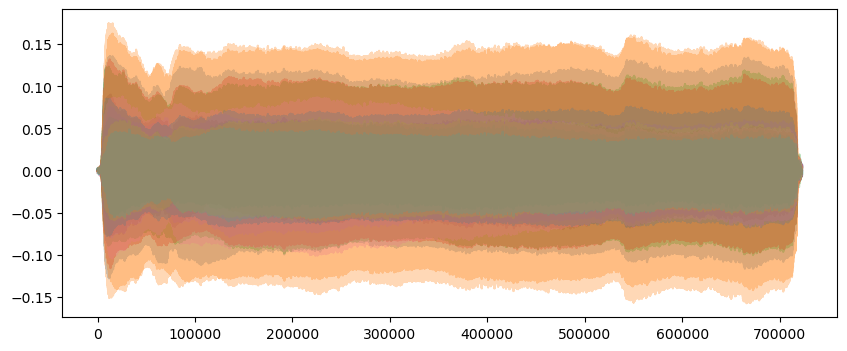

In [4]:
muestra = df.at[0, "Muestra"][:-1] # Un solo fragmento de una nota, droppeado el 13vo canal

plt.subplots(figsize=(10, 4))
for d in range(len(muestra)):
  plt.plot(muestra[d], alpha=0.3)
  
plt.show()

Espectro de la señal

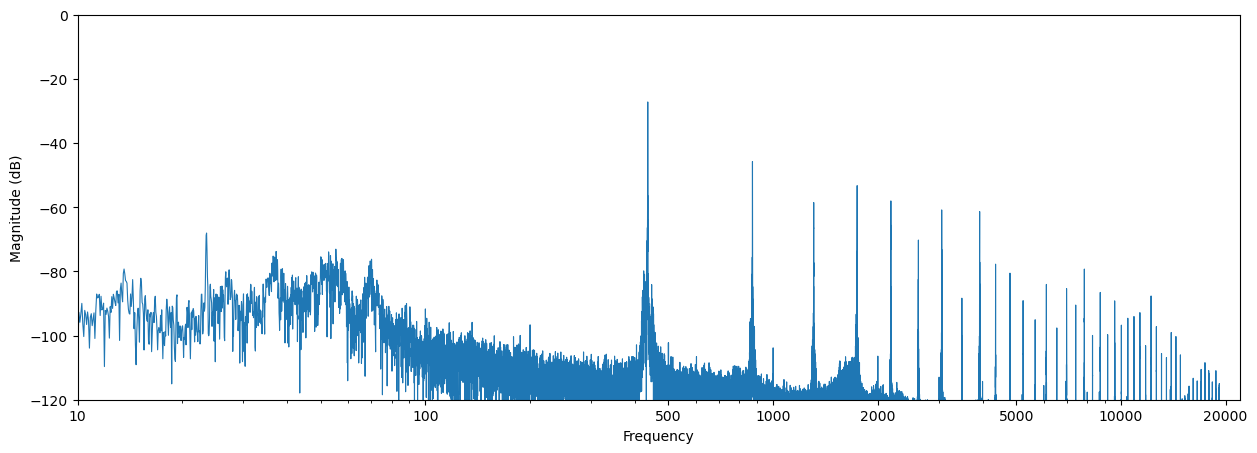

In [9]:
ss = muestra[0]

plt.subplots(figsize=(15,5))
plt.magnitude_spectrum(ss, fs, scale="dB", linewidth= 0.8)
plt.xlim(20, 22000)
plt.xscale("log")
plt.xticks([10, 100, 500, 1000, 2000, 5000, 10000, 20000], ["10", "100", "500", "1000", "2000", "5000", "10000", "20000"])
plt.ylim(-120, 0)
plt.show()

RMS de la señal

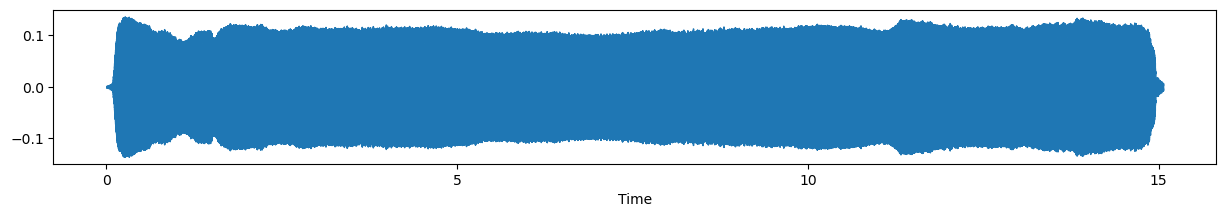

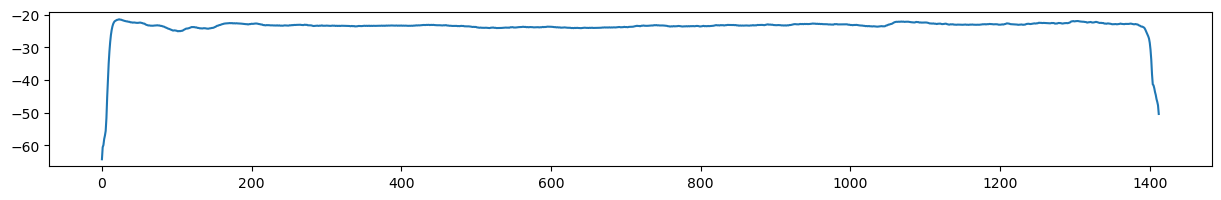

-23.608809

In [97]:
plt.subplots(figsize=(15,2))
li.display.waveshow(ss, sr=fs)
plt.show()

x = li.feature.rms(y=ss)

plt.subplots(figsize=(15,2))
plt.plot(li.amplitude_to_db(x[0]))
plt.show()

np.average(li.amplitude_to_db(x[0]))


Filtro Pasabanda


In [12]:
fc = 600

b, a = signal.butter(4, [fc / np.sqrt(2), fc * np.sqrt(2)], btype="bandpass", fs=fs)
filtrado = signal.filtfilt(b, a, ss)

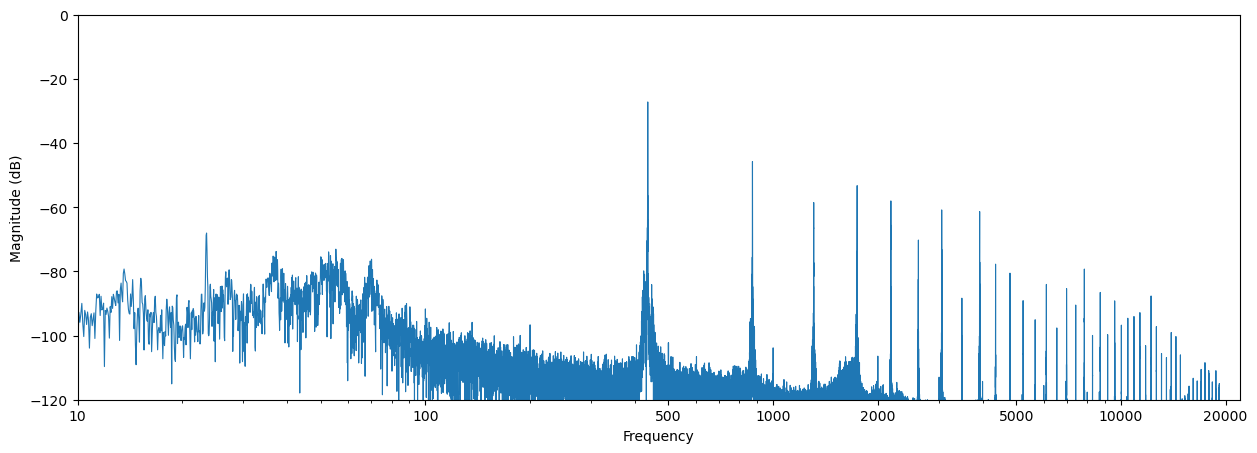

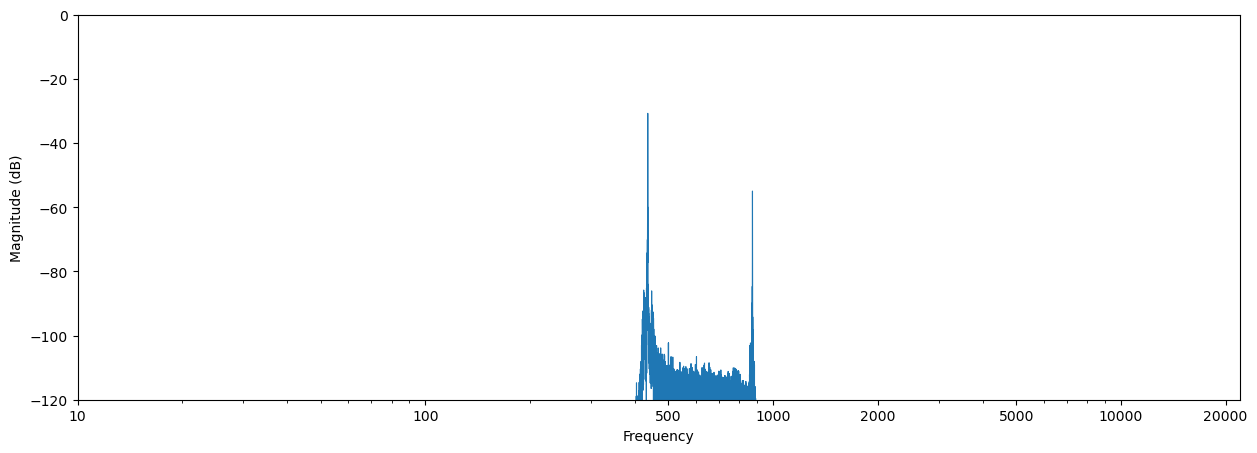

In [13]:
plt.subplots(figsize=(15,5))
plt.magnitude_spectrum(ss, fs, scale="dB", linewidth= 0.8)
plt.xlim(20, 22000)
plt.xscale("log")
plt.xticks([10, 100, 500, 1000, 2000, 5000, 10000, 20000], ["10", "100", "500", "1000", "2000", "5000", "10000", "20000"])
plt.ylim(-120, 0)
plt.show()

plt.subplots(figsize=(15,5))
plt.magnitude_spectrum(filtrado, fs, scale="dB", linewidth= 0.8)
plt.xlim(20, 22000)
plt.xscale("log")
plt.xticks([10, 100, 500, 1000, 2000, 5000, 10000, 20000], ["10", "100", "500", "1000", "2000", "5000", "10000", "20000"])
plt.ylim(-120, 0)
plt.show()


Lista de intensidades en 1 banda por cada canal

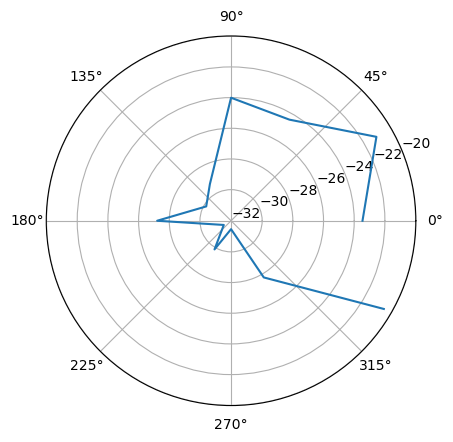

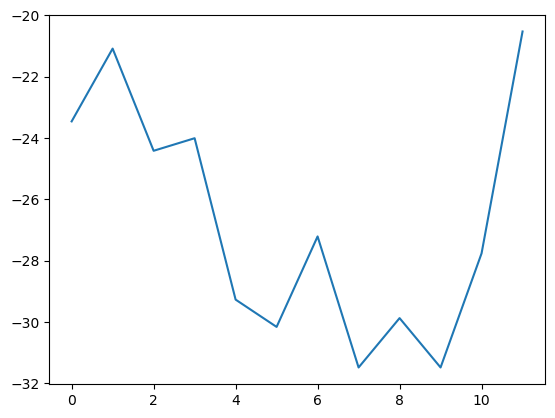

In [55]:
muestra = df.at[0, "Muestra"][:-1] # Un solo fragmento de una nota, droppeado el 13vo canal

# Butterworth bandpass filter
fc = 400
b, a = signal.butter(4, [fc / np.sqrt(2), fc * np.sqrt(2)], btype="bandpass", fs=fs)

values = []

for ch in muestra:
  bandpassed = signal.filtfilt(b, a, ch)
  
  rms = np.average(li.feature.rms(y=bandpassed))
  
  values.append(rms)
  
theta = np.deg2rad(np.arange(0,360,30))

plt.polar(theta, li.amplitude_to_db(values))
plt.show()
plt.plot(li.amplitude_to_db(values))